In [1]:
import numpy as np
import os 
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from openpyxl import Workbook
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.formula.api as smf
import pingouin as pg

In [2]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['legend.facecolor'] = 'white' 

In [34]:
def mediation_analysis(data, x_var, m_var, y_var, conf_level=0.95, bootstrap=5000):

    for var in [x_var, m_var, y_var]:
        if var not in data.columns:
            raise ValueError(f"Variable '{var}' not found in the dataframe")
    
    # Drop rows with missing values in the variables of interest
    data_clean = data[[x_var, m_var, y_var]].dropna()
    
    # Step 1: X -> Y (total effect, c path)
    model_y = smf.ols(f"{y_var} ~ {x_var}", data=data_clean).fit()
    c_coef = model_y.params[x_var]
    c_p = model_y.pvalues[x_var]
    
    # Step 2: X -> M (a path)
    model_m = smf.ols(f"{m_var} ~ {x_var}", data=data_clean).fit()
    a_coef = model_m.params[x_var]
    a_p = model_m.pvalues[x_var]
    
    # Step 3: X + M -> Y (b and c' paths)
    model_ym = smf.ols(f"{y_var} ~ {x_var} + {m_var}", data=data_clean).fit()
    b_coef = model_ym.params[m_var]
    b_p = model_ym.pvalues[m_var]
    c_prime_coef = model_ym.params[x_var]
    c_prime_p = model_ym.pvalues[x_var]
    
    # Calculate indirect effect (a*b)
    ab_coef = a_coef * b_coef
    
    # Bootstrap confidence interval for the indirect effect
    n_samples = len(data_clean)
    ab_bootstrap = []
    
    for _ in range(bootstrap):
        # Sample with replacement
        indices = np.random.choice(range(n_samples), size=n_samples, replace=True)
        boot_sample = data_clean.iloc[indices]
        
        # X -> M (a path)
        boot_model_m = smf.ols(f"{m_var} ~ {x_var}", data=boot_sample).fit()
        boot_a = boot_model_m.params[x_var]
        
        # X + M -> Y (b path)
        boot_model_ym = smf.ols(f"{y_var} ~ {x_var} + {m_var}", data=boot_sample).fit()
        boot_b = boot_model_ym.params[m_var]
        
        # Indirect effect
        ab_bootstrap.append(boot_a * boot_b)
    
    # Calculate bootstrap confidence interval
    alpha = 1 - conf_level
    ci_lower = np.percentile(ab_bootstrap, alpha/2 * 100)
    ci_upper = np.percentile(ab_bootstrap, (1 - alpha/2) * 100)
    
    # Determine if mediation occurred
    direct_effect = c_prime_coef
    total_effect = c_coef
    indirect_effect = ab_coef
    proportion_mediated = indirect_effect / total_effect if total_effect != 0 else 0
    
    # Determine mediation type
    significant_a = a_p < 0.05
    significant_b = b_p < 0.05
    significant_c = c_p < 0.05
    significant_c_prime = c_prime_p < 0.05
    indirect_significant = (ci_lower > 0 and ci_upper > 0) or (ci_lower < 0 and ci_upper < 0)
    
    if significant_a and significant_b and indirect_significant:
        if significant_c and not significant_c_prime:
            mediation_type = "Complete mediation"
        elif significant_c and significant_c_prime:
            mediation_type = "Partial mediation"
        else:
            mediation_type = "Indirect-only mediation"
    else:
        mediation_type = "No mediation"

    results = {
        "total_effect": {
            "path": "c (X→Y)",
            "coefficient": c_coef,
            "p_value": c_p,
            "significant": c_p < 0.05
        },
        "direct_effect": {
            "path": "c' (X→Y controlling for M)",
            "coefficient": c_prime_coef,
            "p_value": c_prime_p,
            "significant": c_prime_p < 0.05
        },
        "a_path": {
            "path": "a (X→M)",
            "coefficient": a_coef,
            "p_value": a_p,
            "significant": a_p < 0.05
        },
        "b_path": {
            "path": "b (M→Y controlling for X)",
            "coefficient": b_coef,
            "p_value": b_p,
            "significant": b_p < 0.05
        },
        "indirect_effect": {
            "path": "a*b (X→M→Y)",
            "coefficient": ab_coef,
            "ci_lower": ci_lower,
            "ci_upper": ci_upper,
            "significant": indirect_significant
        },
        "proportion_mediated": proportion_mediated,
        "mediation_type": mediation_type,
        "sample_size": n_samples,
        "bootstrap_samples": bootstrap,
        "confidence_level": conf_level
    }
    
    return results


def print_mediation_results(results):


    c = results['total_effect']
    print(f"\nTotal effect {c['path']}:")
    print(f"  Coefficient: {c['coefficient']:.4f}")
    print(f"  p-value: {c['p_value']:.4f} ({'significant' if c['significant'] else 'not significant'})")
    
    # a path
    a = results['a_path']
    print(f"\nPath {a['path']}:")
    print(f"  Coefficient: {a['coefficient']:.4f}")
    print(f"  p-value: {a['p_value']:.4f} ({'significant' if a['significant'] else 'not significant'})")
    
    # b path
    b = results['b_path']
    print(f"\nPath {b['path']}:")
    print(f"  Coefficient: {b['coefficient']:.4f}")
    print(f"  p-value: {b['p_value']:.4f} ({'significant' if b['significant'] else 'not significant'})")
    
    # Direct effect (c' path)
    c_prime = results['direct_effect']
    print(f"\nDirect effect {c_prime['path']}:")
    print(f"  Coefficient: {c_prime['coefficient']:.4f}")
    print(f"  p-value: {c_prime['p_value']:.4f} ({'significant' if c_prime['significant'] else 'not significant'})")
    
    # Indirect effect (a*b)
    ab = results['indirect_effect']
    conf_level = results['confidence_level'] * 100
    print(f"\nIndirect effect {ab['path']}:")
    print(f"  Coefficient: {ab['coefficient']:.4f}")
    print(f"  {conf_level}% CI: [{ab['ci_lower']:.4f}, {ab['ci_upper']:.4f}]")
    print(f"  ({'significant' if ab['significant'] else 'not significant'})")
    

In [4]:
df_reward = pd.read_excel('reward_quest.xlsx')
df_punish = pd.read_excel('punishment_quest.xlsx')
df_mixed = pd.read_excel('mixed_quest.xlsx')
df_p_memory1 = pd.read_csv('punishment_memory_summary.csv')
df_r_memory1 = pd.read_csv('reward_memory_summary.csv')
df_m_memory1 = pd.read_csv('mixed_memory_summary.csv')
df_m_fmri = pd.read_csv('mixed_fmribehav_summary.csv')
df_r_fmri = pd.read_csv('reward_fmribehav_summary.csv')
df_p_fmri = pd.read_csv('punishment_fmribehav_summary.csv')

In [5]:
df_p_memory1['rt'] = pd.to_numeric(df_p_memory1['rt'], errors='coerce')
df_p_memory1 = df_p_memory1.dropna(subset=['rt'])
df_r_memory1['rt'] = pd.to_numeric(df_r_memory1['rt'], errors='coerce')
df_r_memory1 = df_r_memory1.dropna(subset=['rt'])
df_m_memory1['rt'] = pd.to_numeric(df_m_memory1['rt'], errors='coerce')
df_m_memory1 = df_m_memory1.dropna(subset=['rt'])

In [6]:
df_m_memory1['meta'] = 1 - (df_m_memory1['accuracy'] - df_m_memory1['confidence']/100)**2
df_r_memory1['meta'] = 1 - (df_r_memory1['accuracy'] - df_r_memory1['confidence']/100)**2
df_p_memory1['meta'] = 1 - (df_p_memory1['accuracy'] - df_p_memory1['confidence']/100)**2

In [7]:
df_r_memory = df_r_memory1.groupby(['subject_nr', 'menu', 'stage', 'condition']).agg(
    acc=('accuracy', 'mean'),
    conf=('confidence', 'mean'),
    meta=('meta', 'mean'),
    AUC=('AUC', 'mean'),
    RT=('rt', 'mean'),
    MAD=('MAD', 'mean')
).reset_index()

df_m_memory = df_m_memory1.groupby(['subject_nr', 'menu', 'stage', 'condition']).agg(
    acc=('accuracy', 'mean'),
    conf=('confidence', 'mean'),
    meta=('meta', 'mean'),
    AUC=('AUC', 'mean'),
    RT=('rt', 'mean'),
    MAD=('MAD', 'mean')
).reset_index()

df_p_memory = df_p_memory1.groupby(['subject_nr', 'menu', 'stage', 'condition']).agg(
    acc=('accuracy', 'mean'),
    conf=('confidence', 'mean'),
    meta=('meta', 'mean'),
    AUC=('AUC', 'mean'),
    RT=('rt', 'mean'),
    MAD=('MAD', 'mean')
).reset_index()

In [8]:
sub_list_reward = df_r_memory['subject_nr'].unique()
cond_list_reward = df_r_memory['condition'].unique()
stage_list_reward = df_r_memory['stage'].unique()
print(len(sub_list_reward))

sub_list_punishment = df_p_memory['subject_nr'].unique()
cond_list_punishment = df_p_memory['condition'].unique()
stage_list_punishment = df_p_memory['stage'].unique()
print(len(sub_list_punishment))

sub_list_mixed = df_m_memory['subject_nr'].unique()
cond_list_mixed= df_m_memory['condition'].unique()
stage_list_mixed= df_m_memory['stage'].unique()
print(len(sub_list_mixed))

37
55
41


计算被试信息（好像没有用到）

In [9]:
overall_age = np.array([])
overall_gender = np.array([])
for sub in sub_list_mixed:
    overall_age = np.append(overall_age, df_mixed.loc[df_mixed['被试编号（请询问主试）'] == sub, '年龄'].values[0])
    overall_gender = np.append(overall_gender, df_mixed.loc[df_mixed['被试编号（请询问主试）'] == sub, '您的性别：'].values[0])

Back to the normal Analysis

In [10]:
df_r_fmri['reward_prob_1'] = df_r_fmri['money_prob_1']
df_r_fmri['reward_prob_2'] = df_r_fmri['money_prob_2']
df_p_fmri['reward_prob_1'] = 10 - df_p_fmri['electric_prob_1']
df_p_fmri['reward_prob_2'] = 10 - df_p_fmri['electric_prob_2']

Calculate the lie rate

In [11]:
def calculate_lierate(fmridata, sub_list):
    # Filter data
    fmridata = fmridata[fmridata['subj'].isin(sub_list)]
    fmridata = fmridata[fmridata['rt'] <= 4]
    fmridata.reset_index(drop=True, inplace=True)
    
    # Initialize reward_sign column
    fmridata['reward_sign'] = -1

    # Calculate reward_sign based on menu positions and probabilities
    for i in range(len(fmridata)):
        menu_position_1 = fmridata.iloc[i]['menu_position_1']
        reward_prob_1 = fmridata.iloc[i]['reward_prob_1']
        reward_prob_2 = fmridata.iloc[i]['reward_prob_2']
        
        if menu_position_1 > 36:
            if reward_prob_1 > reward_prob_2:
                fmridata.loc[i, 'reward_sign'] = 1  # Using .loc to avoid SettingWithCopyWarning
            elif reward_prob_1 < reward_prob_2:
                fmridata.loc[i, 'reward_sign'] = 0
        else:
            if reward_prob_1 > reward_prob_2:
                fmridata.loc[i, 'reward_sign'] = 0
            elif reward_prob_1 < reward_prob_2:
                fmridata.loc[i, 'reward_sign'] = 1

    # Calculate reward_gain based on choices
    fmridata['reward_gain'] = None
    for i in range(len(fmridata)):
        menu_position_1 = fmridata.iloc[i]['menu_position_1']
        menu_position_2 = fmridata.iloc[i]['menu_position_2']
        choose = fmridata.iloc[i]['choose']
        
        if pd.notna(menu_position_1) and pd.notna(choose) and menu_position_1 == choose:
            fmridata.loc[i, 'reward_gain'] = fmridata.iloc[i]['reward_prob_1']
        elif pd.notna(menu_position_2) and pd.notna(choose) and menu_position_2 == choose:
            fmridata.loc[i, 'reward_gain'] = fmridata.iloc[i]['reward_prob_2']
            
    return fmridata

In [12]:
df_p_fmri2 = calculate_lierate(df_p_fmri,sub_list_punishment)
df_r_fmri2 = calculate_lierate(df_r_fmri,sub_list_reward)
df_m_fmri2 = calculate_lierate(df_m_fmri,sub_list_mixed)

In [13]:
df_r_fmri2

,subj,trial,round,menu,menu_position_1,menu_position_2,true_answer,condition,reinforcer,money_prob_1,...,islie,session,diff,former_lie,former_honest,former_diff,reward_prob_1,reward_prob_2,reward_sign,reward_gain
0,101,1,1,1,1,37,1,enhance_honesty,4,8,...,0,1,-4,0,0,0,8,4,0,8
1,101,2,1,25,25,61,25,enhance_honesty,2,4,...,0,1,-2,0,0,0,4,2,0,4
2,101,3,1,6,6,42,6,enhance_random,6,9,...,0,1,-6,0,0,0,9,3,0,9
3,101,4,1,2,38,2,2,enhance_lie,8,9,...,1,1,8,0,0,0,9,1,1,9
4,101,5,1,9,45,9,9,enhance_random,6,1,...,0,1,-6,0,0,0,1,7,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10453,143,68,8,32,32,68,32,enhance_lie,2,6,...,0,4,2,0,7,-7,6,8,1,6
10454,143,69,8,27,63,27,27,enhance_random,8,1,...,0,4,-8,1,6,-5,1,9,0,9
10455,143,70,8,30,66,30,30,enhance_random,6,2,...,0,4,-6,0,7,-7,2,8,0,8
10456,143,71,8,11,47,11,11,enhance_lie,2,8,...,0,4,2,0,7,-7,8,6,1,6


In [14]:
def agg_entropy(fmridata):   
    # Calculate lie-rate for each subject, menu, and condition
    agg_menu = fmridata.groupby(['subj', 'menu', 'condition']).agg(
        lierate=('islie', 'mean'),
        scan_rt=('rt', lambda x: np.mean(pd.to_numeric(x, errors='coerce'))),
        reward_sign=('reward_sign', 'mean'),
        reward_gain_sum=('reward_gain', 'sum')
    ).reset_index()

    agg_menu['entropy'] = -agg_menu['lierate'] * np.log2(agg_menu['lierate']) - \
                            (1 - agg_menu['lierate']) * np.log2(1 - agg_menu['lierate'])

    # Handle edge cases where lierate is 0 or 1
    agg_menu.loc[agg_menu['lierate'] == 1, 'entropy'] = 0
    agg_menu.loc[agg_menu['lierate'] == 0, 'entropy'] = 0

    # Calculate average lie-rate per subject and condition
    agg_entropy = agg_menu.groupby(['subj', 'condition']).agg(
        lierate=('lierate', 'mean'),
        entropy=('entropy', 'mean')
    ).reset_index()

    agg_entropy_all = agg_menu.groupby(['subj']).agg(
        lierate=('lierate', 'mean'),
        entropy=('entropy', 'mean')
    ).reset_index()
     
    return agg_entropy, agg_menu, agg_entropy_all

In [15]:
agg_p_lie_entro, agg_p_menu, agg_p_entropy_all = agg_entropy(df_p_fmri2)
agg_r_lie_entro, agg_r_menu, agg_r_entropy_all = agg_entropy(df_r_fmri2)
agg_m_lie_entro, agg_m_menu, agg_m_entropy_all = agg_entropy(df_m_fmri2)
agg_p_lie_entro

c:\Users\18611\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\18611\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\18611\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,subj,condition,lierate,entropy
0,101,enhance_honesty,0.000000,0.000000
1,101,enhance_lie,0.683036,0.780791
2,101,enhance_random,0.406250,0.925701
3,102,enhance_honesty,0.000000,0.000000
4,102,enhance_lie,0.781250,0.690223
...,...,...,...,...
160,159,enhance_lie,0.651786,0.716982
161,159,enhance_random,0.276786,0.760941
162,160,enhance_honesty,0.020833,0.090594
163,160,enhance_lie,0.677083,0.680176


Compare the enahnce lie and ehance honest and random, lie rate

In [16]:
anova_table = pg.anova(data=agg_r_lie_entro, dv='lierate', between='condition', detailed=True)
print(anova_table)
tukey = pairwise_tukeyhsd(endog=agg_r_lie_entro['lierate'], groups=agg_r_lie_entro['condition'], alpha=0.05)
print(tukey)

      Source        SS   DF        MS           F         p-unc       np2
0  condition  3.670266    2  1.835133  101.917879  1.357949e-25  0.653664
1     Within  1.944648  108  0.018006         NaN           NaN       NaN
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1         group2     meandiff p-adj  lower   upper  reject
--------------------------------------------------------------------
enhance_honesty    enhance_lie   0.4447   0.0  0.3706  0.5189   True
enhance_honesty enhance_random   0.2012   0.0  0.1271  0.2753   True
    enhance_lie enhance_random  -0.2435   0.0 -0.3177 -0.1694   True
--------------------------------------------------------------------


In [17]:
anova_table = pg.anova(data=agg_p_lie_entro, dv='lierate', between='condition', detailed=True)
print(anova_table)
tukey = pairwise_tukeyhsd(endog=agg_p_lie_entro['lierate'], groups=agg_p_lie_entro['condition'], alpha=0.05)
print(tukey)

      Source        SS   DF        MS           F         p-unc       np2
0  condition  9.936865    2  4.968433  395.345721  4.737866e-63  0.829955
1     Within  2.035904  162  0.012567         NaN           NaN       NaN
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1         group2     meandiff p-adj  lower   upper  reject
--------------------------------------------------------------------
enhance_honesty    enhance_lie   0.6011   0.0  0.5505  0.6517   True
enhance_honesty enhance_random   0.2984   0.0  0.2479   0.349   True
    enhance_lie enhance_random  -0.3027   0.0 -0.3532 -0.2521   True
--------------------------------------------------------------------


In [18]:
anova_table = pg.anova(data=agg_m_lie_entro, dv='lierate', between='condition', detailed=True)
print(anova_table)
tukey = pairwise_tukeyhsd(endog=agg_m_lie_entro['lierate'], groups=agg_m_lie_entro['condition'], alpha=0.05)
print(tukey)

      Source        SS   DF        MS           F         p-unc       np2
0  condition  9.674604    2  4.837302  219.061304  8.853151e-41  0.784993
1     Within  2.649835  120  0.022082         NaN           NaN       NaN
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1         group2     meandiff p-adj  lower   upper  reject
--------------------------------------------------------------------
enhance_honesty    enhance_lie   0.6869   0.0  0.6091  0.7648   True
enhance_honesty enhance_random    0.349   0.0  0.2711  0.4269   True
    enhance_lie enhance_random   -0.338   0.0 -0.4158 -0.2601   True
--------------------------------------------------------------------


In [19]:
agg_p_lie_enlie = agg_p_lie_entro[agg_p_lie_entro['condition'] == 'enhance_lie']['lierate'].values
agg_p_lie_enhon = agg_p_lie_entro[agg_p_lie_entro['condition'] == 'enhance_honesty']['lierate'].values
agg_p_lie_random = agg_p_lie_entro[agg_p_lie_entro['condition'] == 'enhance_random']['lierate'].values


agg_r_lie_enlie = agg_r_lie_entro[agg_r_lie_entro['condition'] == 'enhance_lie']['lierate'].values
agg_r_lie_enhon = agg_r_lie_entro[agg_r_lie_entro['condition'] == 'enhance_honesty']['lierate'].values
agg_r_lie_random = agg_r_lie_entro[agg_r_lie_entro['condition'] == 'enhance_random']['lierate'].values


agg_m_lie_enlie = agg_m_lie_entro[agg_m_lie_entro['condition'] == 'enhance_lie']['lierate'].values
agg_m_lie_enhon = agg_m_lie_entro[agg_m_lie_entro['condition'] == 'enhance_honesty']['lierate'].values
agg_m_lie_random = agg_m_lie_entro[agg_m_lie_entro['condition'] == 'enhance_random']['lierate'].values


In [20]:
data = {
    'score': np.concatenate([agg_p_lie_enlie, agg_r_lie_enlie, agg_m_lie_enlie]),
    'group': ['punishment'] * len(agg_p_lie_enlie) + ['reward'] * len(agg_r_lie_enlie) + ['mixed'] * len(agg_m_lie_enlie)
}
df = pd.DataFrame(data)
model = ols('score ~ C(group)', data=df).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
tukey = pairwise_tukeyhsd(endog=df['score'], groups=df['group'], alpha=0.05)

print('***enhance_lie***',anova_table,tukey)


***enhance_lie***             sum_sq     df         F    PR(>F)
C(group)  0.577665    2.0  8.561717  0.000321
Residual  4.385592  130.0       NaN       NaN     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
     mixed punishment  -0.0859  0.064 -0.1758  0.0039  False
     mixed     reward  -0.1723 0.0002  -0.271 -0.0735   True
punishment     reward  -0.0863 0.0732 -0.1789  0.0063  False
------------------------------------------------------------


In [ ]:
data = {
    'score': np.concatenate([agg_p_lie_enhon, agg_r_lie_enhon, agg_m_lie_enhon]),
    'group': ['punishment'] * len(agg_p_lie_enhon) + ['reward'] * len(agg_r_lie_enhon) + ['mixed'] * len(agg_m_lie_enhon)
}
df = pd.DataFrame(data)
model = ols('score ~ C(group)', data=df).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
tukey = pairwise_tukeyhsd(endog=df['score'], groups=df['group'], alpha=0.05)



print('***enhance_hon***',anova_table,tukey)


***enhance_hon***             sum_sq     df          F    PR(>F)
C(group)  0.130908    2.0  14.041334  0.000003
Residual  0.605996  130.0        NaN       NaN    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj  lower  upper  reject
----------------------------------------------------------
     mixed punishment  -0.0001   1.0 -0.0335 0.0333  False
     mixed     reward   0.0699   0.0  0.0332 0.1067   True
punishment     reward   0.0701   0.0  0.0356 0.1045   True
----------------------------------------------------------


In [22]:
data = {
    'score': np.concatenate([agg_p_lie_random, agg_r_lie_random, agg_m_lie_random]),
    'group': ['punishment'] * len(agg_p_lie_random) + ['reward'] * len(agg_r_lie_random) + ['mixed'] * len(agg_m_lie_random)
}
df = pd.DataFrame(data)
model = ols('score ~ C(group)', data=df).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
tukey = pairwise_tukeyhsd(endog=df['score'], groups=df['group'], alpha=0.05)

# Display results

print('***random***',anova_table,tukey)

***random***             sum_sq     df         F    PR(>F)
C(group)  0.123924    2.0  4.915229  0.008754
Residual  1.638799  130.0       NaN       NaN     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
     mixed punishment  -0.0507 0.0772 -0.1056  0.0043  False
     mixed     reward  -0.0778 0.0076 -0.1382 -0.0175   True
punishment     reward  -0.0272 0.4925 -0.0838  0.0294  False
------------------------------------------------------------


In [23]:
agg_p_lie = agg_p_entropy_all['lierate'].values
agg_r_lie = agg_r_entropy_all['lierate'].values
agg_m_lie = agg_m_entropy_all['lierate'].values


data = {
    'score': np.concatenate([agg_p_lie, agg_r_lie, agg_m_lie]),
    'group': ['punishment'] * len(agg_p_lie) + ['reward'] * len(agg_r_lie) + ['mixed'] * len(agg_m_lie)
}
df = pd.DataFrame(data)
model = ols('score ~ C(group)', data=df).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
tukey = pairwise_tukeyhsd(endog=df['score'], groups=df['group'], alpha=0.05)

# Display results


print(anova_table,tukey)


            sum_sq     df         F    PR(>F)
C(group)  0.079553    2.0  4.356696  0.014744
Residual  1.186902  130.0       NaN       NaN     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
     mixed punishment  -0.0456 0.0577 -0.0923  0.0012  False
     mixed     reward    -0.06 0.0175 -0.1114 -0.0087   True
punishment     reward  -0.0145 0.7566 -0.0626  0.0337  False
------------------------------------------------------------


Calculate the memory change

In [24]:
def calculate_metric(data, metric, sub_list, cond_list, stage_list):
    result = np.zeros((len(sub_list), len(cond_list), len(stage_list)))
    
    for i, sub in enumerate(sub_list):
        sub_data = data[data['subject_nr'] == sub]
        for j, cond in enumerate(cond_list):
            cond_data = sub_data[sub_data['condition'] == cond]
            for k, stage in enumerate(stage_list):
                stage_data = cond_data[cond_data['stage'] == stage]
                result[i, j, k] = stage_data[metric].mean()
    
    return result


cond_list = ['enhance_honesty', 'enhance_lie', 'enhance_random']
stage_list = ['pre', 'post', 'post2']

rt_reward = calculate_metric(df_r_memory, 'RT', sub_list_reward, cond_list, stage_list)
accuracy_reward = calculate_metric(df_r_memory, 'acc', sub_list_reward, cond_list, stage_list)
confidence_reward = calculate_metric(df_r_memory, 'conf', sub_list_reward, cond_list, stage_list)
mad_reward = calculate_metric(df_r_memory, 'MAD', sub_list_reward, cond_list, stage_list)
auc_reward = calculate_metric(df_r_memory, 'AUC', sub_list_reward, cond_list, stage_list)
meta_reward = calculate_metric(df_r_memory, 'meta', sub_list_reward, cond_list, stage_list)


rt_punish = calculate_metric(df_p_memory, 'RT', sub_list_punishment, cond_list, stage_list)
accuracy_punish = calculate_metric(df_p_memory, 'acc', sub_list_punishment, cond_list, stage_list)
confidence_punish = calculate_metric(df_p_memory, 'conf', sub_list_punishment, cond_list, stage_list)
mad_punish = calculate_metric(df_p_memory, 'MAD', sub_list_punishment, cond_list, stage_list)
auc_punish = calculate_metric(df_p_memory, 'AUC', sub_list_punishment, cond_list, stage_list)
meta_punish = calculate_metric(df_p_memory, 'meta', sub_list_punishment, cond_list, stage_list)

rt_mixed = calculate_metric(df_m_memory, 'RT', sub_list_mixed, cond_list, stage_list)
accuracy_mixed = calculate_metric(df_m_memory, 'acc', sub_list_mixed, cond_list, stage_list)
confidence_mixed = calculate_metric(df_m_memory, 'conf', sub_list_mixed, cond_list, stage_list)
mad_mixed = calculate_metric(df_m_memory, 'MAD', sub_list_mixed, cond_list, stage_list)
auc_mixed = calculate_metric(df_m_memory, 'AUC', sub_list_mixed, cond_list, stage_list)
meta_mixed = calculate_metric(df_m_memory, 'meta', sub_list_mixed, cond_list, stage_list)

In [25]:
def calculate_relationship(metric_change, agg_data, condition_name, metric_name):
    # Filter data for the specific condition
    agg_stg = agg_data[agg_data['condition'] == condition_name].reset_index(drop=True)
    
    # Extract lie rate and lie entropy
    lie_rate = agg_stg['lierate'].to_numpy()
    lie_entropy = agg_stg['entropy'].to_numpy()
    
    # Calculate linear regression for lie rate
    slope_rate, intercept_rate, r_rate, p_rate, stderr_rate = stats.linregress(lie_rate, metric_change)
    if p_rate < 0.05:
        print(f'{metric_name} significant with lie rate for {condition_name}')
    
    # Calculate linear regression for lie entropy
    slope_entropy, intercept_entropy, r_entropy, p_entropy, stderr_entropy = stats.linregress(lie_entropy, metric_change)
    if p_entropy < 0.05:
        print(f'{metric_name} significant with lie entropy for {condition_name}')


cond_list = ['enhance_honesty', 'enhance_lie', 'enhance_random']


In [26]:
for cond_num, cond_name in enumerate(cond_list):

    acc_change_reward = accuracy_reward[:, cond_num, 0] - accuracy_reward[:, cond_num, 1]
    calculate_relationship(acc_change_reward, agg_r_lie_entro, cond_name, 'reward_acc')
    
    acc_change_punish = accuracy_punish[:, cond_num, 0] - accuracy_punish[:, cond_num, 1]
    calculate_relationship(acc_change_punish, agg_p_lie_entro, cond_name, 'punish_acc')
    
    acc_change_mixed = accuracy_mixed[:, cond_num, 0] - accuracy_mixed[:, cond_num, 1]
    calculate_relationship(acc_change_mixed, agg_m_lie_entro, cond_name, 'mixed_acc')
    
    rt_change_reward = rt_reward[:, cond_num, 0] - rt_reward[:, cond_num, 1]
    calculate_relationship(rt_change_reward, agg_r_lie_entro, cond_name, 'reward_rt')
    
    rt_change_punish = rt_punish[:, cond_num, 0] - rt_punish[:, cond_num, 1] 
    calculate_relationship(rt_change_punish, agg_p_lie_entro, cond_name, 'punish_rt')
    
    rt_change_mixed = rt_mixed[:, cond_num, 0] - rt_mixed[:, cond_num, 1]
    calculate_relationship(rt_change_mixed, agg_m_lie_entro, cond_name, 'mixed_rt')
    
    conf_change_reward = confidence_reward[:, cond_num, 0] - confidence_reward[:, cond_num, 1]
    calculate_relationship(conf_change_reward, agg_r_lie_entro, cond_name, 'reward_conf')
    
    conf_change_punish = confidence_punish[:, cond_num, 0] - confidence_punish[:, cond_num, 1]
    calculate_relationship(conf_change_punish, agg_p_lie_entro, cond_name, 'punish_conf')
    
    conf_change_mixed = confidence_mixed[:, cond_num, 0] - confidence_mixed[:, cond_num, 1]
    calculate_relationship(conf_change_mixed, agg_m_lie_entro, cond_name, 'mixed_conf')
    
    mad_change_reward = mad_reward[:, cond_num, 0] - mad_reward[:, cond_num, 1]
    calculate_relationship(mad_change_reward, agg_r_lie_entro, cond_name, 'reward_mad')
    
    mad_change_punish = mad_punish[:, cond_num, 0] - mad_punish[:, cond_num, 1]
    calculate_relationship(mad_change_punish, agg_p_lie_entro, cond_name, 'punish_mad')
    
    mad_change_mixed = mad_mixed[:, cond_num, 0] - mad_mixed[:, cond_num, 1]
    calculate_relationship(mad_change_mixed, agg_m_lie_entro, cond_name, 'mixed_mad')

    auc_change_reward = auc_reward[:, cond_num, 0] - auc_reward[:, cond_num, 1]
    calculate_relationship(auc_change_reward, agg_r_lie_entro, cond_name, 'reward_auc')
    
    auc_change_punish = auc_punish[:, cond_num, 0] - auc_punish[:, cond_num, 1]
    calculate_relationship(auc_change_punish, agg_p_lie_entro, cond_name, 'punish_auc')
    
    auc_change_mixed = auc_mixed[:, cond_num, 0] - auc_mixed[:, cond_num, 1]
    calculate_relationship(auc_change_mixed, agg_m_lie_entro, cond_name, 'mixed_auc')

    meta_change_reward = meta_reward[:, cond_num, 0] - meta_reward[:, cond_num, 1]
    calculate_relationship(meta_change_reward, agg_r_lie_entro, cond_name, 'reward_meta')
    
    meta_change_punish = meta_punish[:, cond_num, 0] - meta_punish[:, cond_num, 1]
    calculate_relationship(meta_change_punish, agg_p_lie_entro, cond_name, 'punish_meta')
    
    meta_change_mixed = meta_mixed[:, cond_num, 0] - meta_mixed[:, cond_num, 1]
    calculate_relationship(meta_change_mixed, agg_m_lie_entro, cond_name, 'mixed_meta')

reward_rt significant with lie rate for enhance_honesty
mixed_conf significant with lie rate for enhance_honesty
mixed_conf significant with lie entropy for enhance_honesty
punish_meta significant with lie rate for enhance_honesty
mixed_meta significant with lie rate for enhance_honesty
mixed_meta significant with lie entropy for enhance_honesty
mixed_rt significant with lie rate for enhance_lie
reward_mad significant with lie rate for enhance_lie
reward_auc significant with lie rate for enhance_lie
reward_rt significant with lie entropy for enhance_random


Emotion value get

In [27]:
col_name_list_p = df_punish.columns.tolist()
reward_emotion_list = [20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42]
punish_emotion_list = [26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48]
mixed_emotion_list = [26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48]

emotion_list = ['Interested','Distressed','Excited','Upset','Strong','Guilty','Scared','Hostile','Enthusiastic','Proud','Irritable','Alert','Ashamed','Inspired','Nervous','Determined','Attentive','Jittery','Active','Afraid','Pos','Neg','Total']

In [28]:
col_nn = col_name_list_p[punish_emotion_list[0]]
emo_value_p = df_punish[col_nn]
data_punish = np.zeros([len(sub_list_punishment), len(emotion_list)])

for i in range(len(sub_list_punishment)):
    for j in range(len(emotion_list)):
        col_nn = col_name_list_p[punish_emotion_list[j]]
        data_punish[i,j] = df_punish[col_nn][df_punish.iloc[:, 6] == sub_list_punishment[i]].to_numpy()[0]

In [29]:
def plot_correlation_map(df,title_name):
    corr = df.corr()
    p_matrix = np.zeros_like(corr)
    for i in range(len(corr)):
        for j in range(len(corr)):
            _, p_matrix[i, j] = pearsonr(df.iloc[:, i], df.iloc[:, j])

    alpha = 0.05
    mask_significant = p_matrix >= alpha
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(10, 8))
    custom_colors = ["blue", "white", "red"]
    sns.heatmap(corr, mask=mask | mask_significant)
    plt.title(f'Correlation Matrix with {title_name}')
    plt.show()

In [31]:
#save the corrleation matrix and p value matrix into excel file
beh_list = ['lierate','lie_entropy','acc_drop','meta_drop','rt_drop','conf_drop','auc_drop']
data_punish_beh = np.zeros([len(sub_list_punishment), len(beh_list)])
cond_index = 0 #change the condition index for the ['enhance_honesty', 'enhance_lie', 'enhance_random']
cond_list = ['enhance_honesty', 'enhance_lie', 'enhance_random']

for i in range(len(sub_list_punishment)):
    agg_sub = agg_p_lie_entro[agg_p_lie_entro['subj'] == sub_list_punishment[i]]
    data_punish_beh[i,0] = agg_sub[agg_sub['condition'] == cond_list[cond_index]]['lierate'].to_numpy()[0]
    data_punish_beh[i,1] = agg_sub[agg_sub['condition'] == cond_list[cond_index]]['entropy'].to_numpy()[0]


data_punish_beh[:,3] = meta_punish[:,cond_index,0] - meta_punish[:,cond_index,1]
data_punish_beh[:,2] = accuracy_punish[:,cond_index,0] - accuracy_punish[:,cond_index,1]
data_punish_beh[:,4] = np.abs(rt_punish[:,cond_index,0] - rt_punish[:,cond_index,1])
data_punish_beh[:,5] = confidence_punish[:,cond_index,0] - confidence_punish[:,cond_index,1]
data_punish_beh[:,6] = auc_punish[:,cond_index,0] - auc_punish[:,cond_index,1]

data_punish_total = np.concatenate((data_punish, data_punish_beh), axis=1)
column_list = ['Interested','Distressed','Excited','Upset','Strong','Guilty','Scared','Hostile','Enthusiastic','Proud','Irritable','Alert','Ashamed','Inspired','Nervous','Determined','Attentive','Jittery','Active','Afraid','Pos','Neg','Total','lierate','lie_entropy','acc_drop','meta_drop','rt_drop','conf_drop','auc_drop']
df_honesty = pd.DataFrame(data_punish_total, columns=column_list)
corr = df_honesty.corr()
p_matrix = np.zeros_like(corr)
p_value_matrix = pd.DataFrame(p_matrix, index=corr.index, columns=corr.columns)
df_punish_honest = p_value_matrix.applymap(lambda x: round(x, 4))
corr_punish_honest = df_honesty.corr()

###########################################################################################################################
#honesty up
#dishonest down
###########################################################################################################################

#save the corrleation matrix and p value matrix into excel file
beh_list = ['lierate','lie_entropy','acc_drop','meta_drop','rt_drop','conf_drop','auc_drop']
data_punish_beh = np.zeros([len(sub_list_punishment), len(beh_list)])
cond_index = 1 #change the condition index for the ['enhance_honesty', 'enhance_lie', 'enhance_random']
cond_list = ['enhance_honesty', 'enhance_lie', 'enhance_random']

for i in range(len(sub_list_punishment)):
    agg_sub = agg_p_lie_entro[agg_p_lie_entro['subj'] == sub_list_punishment[i]]
    data_punish_beh[i,0] = agg_sub[agg_sub['condition'] == cond_list[cond_index]]['lierate'].to_numpy()[0]
    data_punish_beh[i,1] = agg_sub[agg_sub['condition'] == cond_list[cond_index]]['entropy'].to_numpy()[0]


data_punish_beh[:,3] = meta_punish[:,cond_index,0] - meta_punish[:,cond_index,1]
data_punish_beh[:,2] = accuracy_punish[:,cond_index,0] - accuracy_punish[:,cond_index,1]
data_punish_beh[:,4] = np.abs(rt_punish[:,cond_index,0] - rt_punish[:,cond_index,1])
data_punish_beh[:,5] = confidence_punish[:,cond_index,0] - confidence_punish[:,cond_index,1]
data_punish_beh[:,6] = auc_punish[:,cond_index,0] - auc_punish[:,cond_index,1]

data_punish_total = np.concatenate((data_punish, data_punish_beh), axis=1)
column_list = ['Interested','Distressed','Excited','Upset','Strong','Guilty','Scared','Hostile','Enthusiastic','Proud','Irritable','Alert','Ashamed','Inspired','Nervous','Determined','Attentive','Jittery','Active','Afraid','Pos','Neg','Total','lierate','lie_entropy','acc_drop','meta_drop','rt_drop','conf_drop','auc_drop']
df_dishonesty = pd.DataFrame(data_punish_total, columns=column_list)
corr = df_dishonesty.corr()
p_matrix = np.zeros_like(corr)
p_value_matrix = pd.DataFrame(p_matrix, index=corr.index, columns=corr.columns)
df_punish_dishonest = p_value_matrix.applymap(lambda x: round(x, 4))
corr_punish_dishonest = df_dishonesty.corr()

###########################################################################################################################
#dishonesty up
#random down
###########################################################################################################################

#save the corrleation matrix and p value matrix into excel file
beh_list = ['lierate','lie_entropy','acc_drop','meta_drop','rt_drop','conf_drop','auc_drop']
data_punish_beh = np.zeros([len(sub_list_punishment), len(beh_list)])
cond_index = 2 #change the condition index for the ['enhance_honesty', 'enhance_lie', 'enhance_random']
cond_list = ['enhance_honesty', 'enhance_lie', 'enhance_random']

for i in range(len(sub_list_punishment)):
    agg_sub = agg_p_lie_entro[agg_p_lie_entro['subj'] == sub_list_punishment[i]]
    data_punish_beh[i,0] = agg_sub[agg_sub['condition'] == cond_list[cond_index]]['lierate'].to_numpy()[0]
    data_punish_beh[i,1] = agg_sub[agg_sub['condition'] == cond_list[cond_index]]['entropy'].to_numpy()[0]


data_punish_beh[:,3] = meta_punish[:,cond_index,0] - meta_punish[:,cond_index,1]
data_punish_beh[:,2] = accuracy_punish[:,cond_index,0] - accuracy_punish[:,cond_index,1]
data_punish_beh[:,4] = np.abs(rt_punish[:,cond_index,0] - rt_punish[:,cond_index,1])
data_punish_beh[:,5] = confidence_punish[:,cond_index,0] - confidence_punish[:,cond_index,1]
data_punish_beh[:,6] = auc_punish[:,cond_index,0] - auc_punish[:,cond_index,1]

data_punish_total = np.concatenate((data_punish, data_punish_beh), axis=1)
column_list = ['Interested','Distressed','Excited','Upset','Strong','Guilty','Scared','Hostile','Enthusiastic','Proud','Irritable','Alert','Ashamed','Inspired','Nervous','Determined','Attentive','Jittery','Active','Afraid','Pos','Neg','Total','lierate','lie_entropy','acc_drop','meta_drop','rt_drop','conf_drop','auc_drop']
df_random = pd.DataFrame(data_punish_total, columns=column_list)
corr = df_random.corr()
p_matrix = np.zeros_like(corr)
p_value_matrix = pd.DataFrame(p_matrix, index=corr.index, columns=corr.columns)
df_punish_random = p_value_matrix.applymap(lambda x: round(x, 4))
corr_punish_random = df_random.corr()

C:\Users\18611\AppData\Local\Temp\ipykernel_17816\162424730.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_punish_honest = p_value_matrix.applymap(lambda x: round(x, 4))
C:\Users\18611\AppData\Local\Temp\ipykernel_17816\162424730.py:57: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_punish_dishonest = p_value_matrix.applymap(lambda x: round(x, 4))
C:\Users\18611\AppData\Local\Temp\ipykernel_17816\162424730.py:89: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_punish_random = p_value_matrix.applymap(lambda x: round(x, 4))


In [32]:
file_path = "punish_pvalue.xlsx" # save p value 

# Save DataFrames to different sheets
with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
    df_punish_dishonest.to_excel(writer, sheet_name='dishonest', index=False)
    df_punish_honest.to_excel(writer, sheet_name='honest', index=False)
    df_punish_random.to_excel(writer, sheet_name='random', index=False)
    
    
file_path = "punish_corr.xlsx" # save correlation

# Save DataFrames to different sheets
with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
    corr_punish_dishonest.to_excel(writer, sheet_name='dishonest', index=False)
    corr_punish_honest.to_excel(writer, sheet_name='honest', index=False)
    corr_punish_random.to_excel(writer, sheet_name='random', index=False)

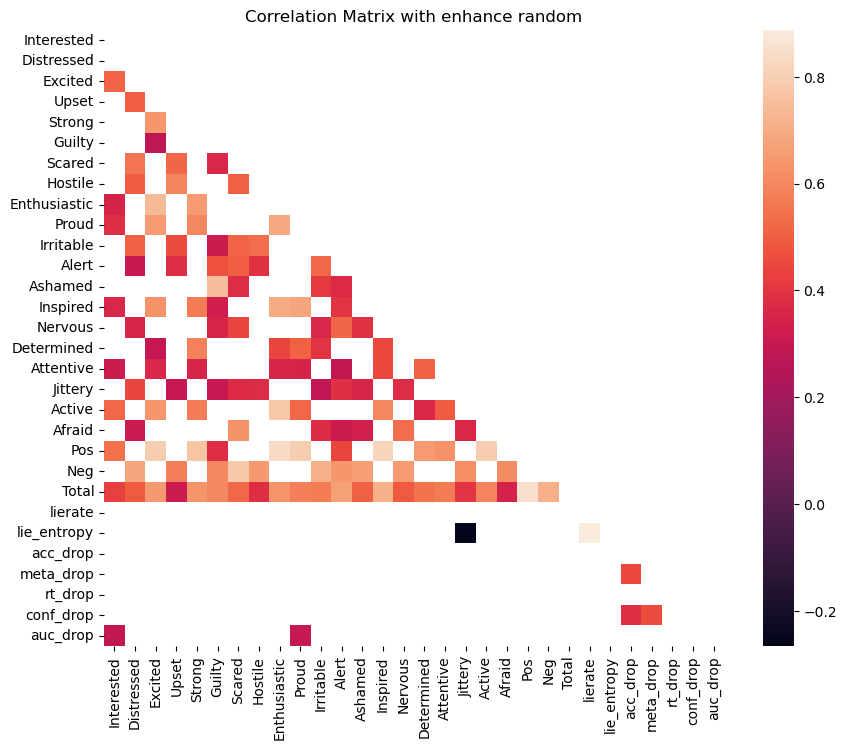

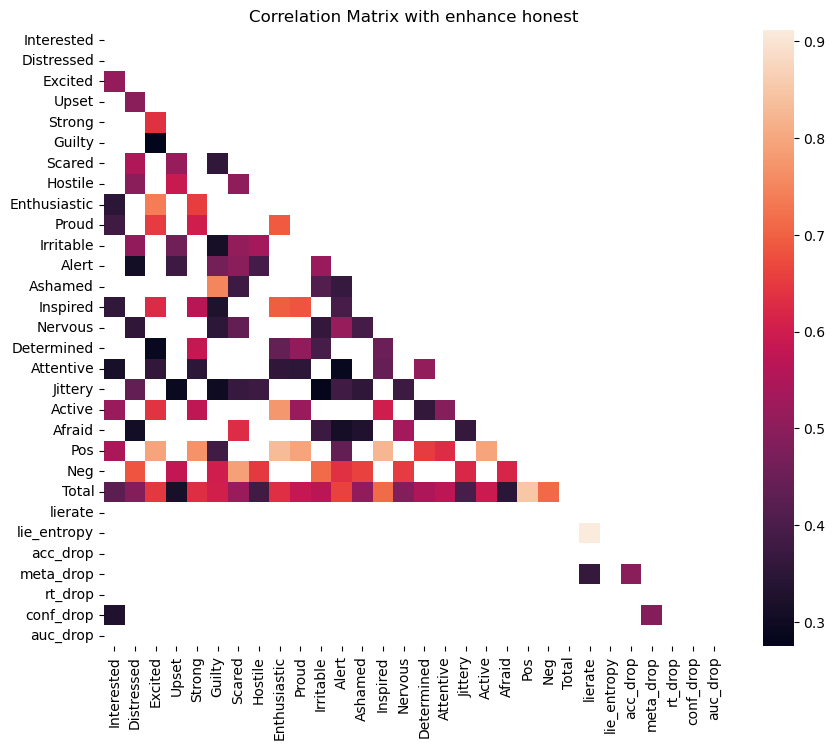

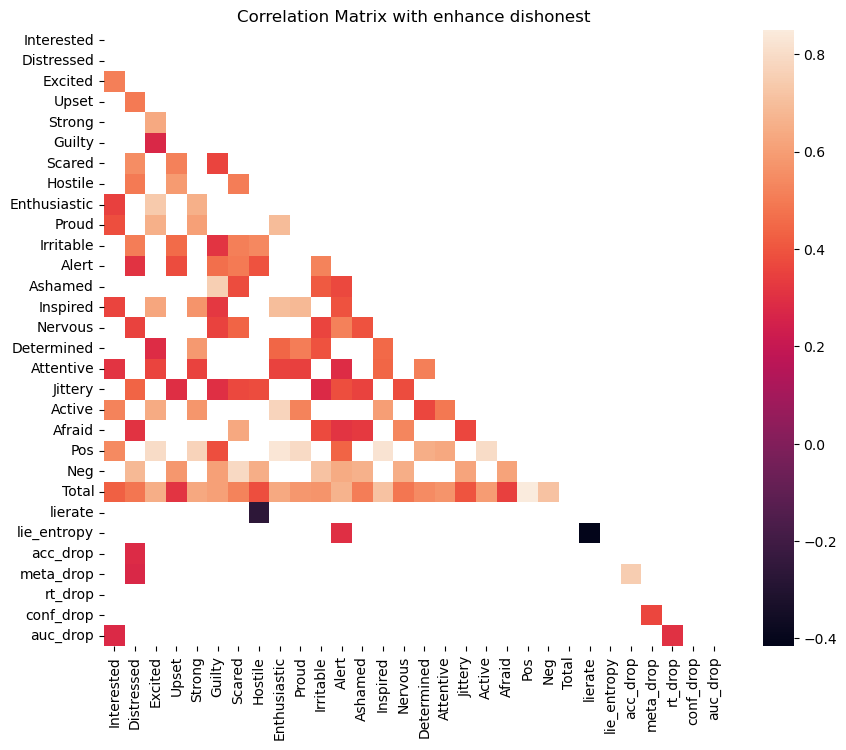

In [33]:
plot_correlation_map(df_random,'enhance random')
plot_correlation_map(df_honesty,'enhance honest')
plot_correlation_map(df_dishonesty,'enhance dishonest')

In [35]:
results = mediation_analysis(df_dishonesty, 'lierate', 'Guilty', 'acc_drop')
print_mediation_results(results)


Total effect c (X→Y):
  Coefficient: 0.0061
  p-value: 0.8934 (not significant)

Path a (X→M):
  Coefficient: 0.4922
  p-value: 0.5508 (not significant)

Path b (M→Y controlling for X):
  Coefficient: 0.0004
  p-value: 0.9631 (not significant)

Direct effect c' (X→Y controlling for M):
  Coefficient: 0.0060
  p-value: 0.8977 (not significant)

Indirect effect a*b (X→M→Y):
  Coefficient: 0.0002
  95.0% CI: [-0.0212, 0.0103]
  (not significant)


Reward 

In [36]:
data_reward = np.zeros([len(sub_list_reward), len(emotion_list)])

for i in range(len(sub_list_reward)):
    for j in range(len(emotion_list)):
        col_nn = col_name_list_p[punish_emotion_list[j]]
        data_reward[i,j] = df_reward[col_nn][df_reward.iloc[:, 1] == sub_list_reward[i]].to_numpy()[0]

In [37]:
beh_list = ['lierate','lie_entropy','acc_drop','meta_drop','rt_drop','conf_drop','auc_drop']
data_beh = np.zeros([len(sub_list_reward), len(beh_list)])
cond_index = 0 #change the condition index for the ['enhance_honesty', 'enhance_lie', 'enhance_random']
cond_list = ['enhance_honesty', 'enhance_lie', 'enhance_random']
for i in range(len(sub_list_reward)):
    agg_sub = agg_r_lie_entro[agg_r_lie_entro['subj'] == sub_list_reward[i]]
    data_beh[i,0] = agg_sub[agg_sub['condition'] == cond_list[cond_index]]['lierate'].to_numpy()[0]
    data_beh[i,1] = agg_sub[agg_sub['condition'] == cond_list[cond_index]]['entropy'].to_numpy()[0]


data_beh[:,3] = meta_reward[:,cond_index,0] - meta_reward[:,cond_index,1]
data_beh[:,2] = accuracy_reward[:,cond_index,0] - accuracy_reward[:,cond_index,1]
data_beh[:,4] = np.abs(rt_reward[:,cond_index,0] - rt_reward[:,cond_index,1])
data_beh[:,5] = confidence_reward[:,cond_index,0] - confidence_reward[:,cond_index,1]
data_beh[:,6] = auc_reward[:,cond_index,0] - auc_reward[:,cond_index,1]

data_total = np.concatenate((data_reward, data_beh), axis=1)
column_list = ['Interested','Distressed','Excited','Upset','Strong','Guilty','Scared','Hostile','Enthusiastic','Proud','Irritable','Alert','Ashamed','Inspired','Nervous','Determined','Attentive','Jittery','Active','Afraid','Pos','Neg','Total','lierate','lie_entropy','acc_drop','meta_drop','rt_drop','conf_drop','auc_drop']
df_honesty = pd.DataFrame(data_total, columns=column_list)

corr = df_honesty.corr()
p_matrix = np.zeros_like(corr)
p_value_matrix = pd.DataFrame(p_matrix, index=corr.index, columns=corr.columns)
df_reward_honest = p_value_matrix.applymap(lambda x: round(x, 4))
corr_reward_honest = df_honesty.corr()

###########################################################################################################################
#honesty up
#dishonest down
###########################################################################################################################

beh_list = ['lierate','lie_entropy','acc_drop','meta_drop','rt_drop','conf_drop','auc_drop']
data_beh = np.zeros([len(sub_list_reward), len(beh_list)])
cond_index = 1 #change the condition index for the ['enhance_honesty', 'enhance_lie', 'enhance_random']
cond_list = ['enhance_honesty', 'enhance_lie', 'enhance_random']
for i in range(len(sub_list_reward)):
    agg_sub = agg_r_lie_entro[agg_r_lie_entro['subj'] == sub_list_reward[i]]
    data_beh[i,0] = agg_sub[agg_sub['condition'] == cond_list[cond_index]]['lierate'].to_numpy()[0]
    data_beh[i,1] = agg_sub[agg_sub['condition'] == cond_list[cond_index]]['entropy'].to_numpy()[0]


data_beh[:,3] = meta_reward[:,cond_index,0] - meta_reward[:,cond_index,1]
data_beh[:,2] = accuracy_reward[:,cond_index,0] - accuracy_reward[:,cond_index,1]
data_beh[:,4] = np.abs(rt_reward[:,cond_index,0] - rt_reward[:,cond_index,1])
data_beh[:,5] = confidence_reward[:,cond_index,0] - confidence_reward[:,cond_index,1]
data_beh[:,6] = auc_reward[:,cond_index,0] - auc_reward[:,cond_index,1]

data_total = np.concatenate((data_reward, data_beh), axis=1)
column_list = ['Interested','Distressed','Excited','Upset','Strong','Guilty','Scared','Hostile','Enthusiastic','Proud','Irritable','Alert','Ashamed','Inspired','Nervous','Determined','Attentive','Jittery','Active','Afraid','Pos','Neg','Total','lierate','lie_entropy','acc_drop','meta_drop','rt_drop','conf_drop','auc_drop']
df_dishonesty = pd.DataFrame(data_total, columns=column_list)

corr = df_dishonesty.corr()
p_matrix = np.zeros_like(corr)
p_value_matrix = pd.DataFrame(p_matrix, index=corr.index, columns=corr.columns)
df_reward_dishonest = p_value_matrix.applymap(lambda x: round(x, 4))
corr_reward_dishonest = df_dishonesty.corr()


###########################################################################################################################
#dishonesty up
#random down
###########################################################################################################################

beh_list = ['lierate','lie_entropy','acc_drop','meta_drop','rt_drop','conf_drop','auc_drop']
data_beh = np.zeros([len(sub_list_reward), len(beh_list)])
cond_index = 2 #change the condition index for the ['enhance_honesty', 'enhance_lie', 'enhance_random']
cond_list = ['enhance_honesty', 'enhance_lie', 'enhance_random']
for i in range(len(sub_list_reward)):
    agg_sub = agg_r_lie_entro[agg_r_lie_entro['subj'] == sub_list_reward[i]]
    data_beh[i,0] = agg_sub[agg_sub['condition'] == cond_list[cond_index]]['lierate'].to_numpy()[0]
    data_beh[i,1] = agg_sub[agg_sub['condition'] == cond_list[cond_index]]['entropy'].to_numpy()[0]


data_beh[:,3] = meta_reward[:,cond_index,0] - meta_reward[:,cond_index,1]
data_beh[:,2] = accuracy_reward[:,cond_index,0] - accuracy_reward[:,cond_index,1]
data_beh[:,4] = np.abs(rt_reward[:,cond_index,0] - rt_reward[:,cond_index,1])
data_beh[:,5] = confidence_reward[:,cond_index,0] - confidence_reward[:,cond_index,1]
data_beh[:,6] = auc_reward[:,cond_index,0] - auc_reward[:,cond_index,1]

data_total = np.concatenate((data_reward, data_beh), axis=1)
column_list = ['Interested','Distressed','Excited','Upset','Strong','Guilty','Scared','Hostile','Enthusiastic','Proud','Irritable','Alert','Ashamed','Inspired','Nervous','Determined','Attentive','Jittery','Active','Afraid','Pos','Neg','Total','lierate','lie_entropy','acc_drop','meta_drop','rt_drop','conf_drop','auc_drop']
df_random = pd.DataFrame(data_total, columns=column_list)

corr = df_random.corr()
p_matrix = np.zeros_like(corr)
p_value_matrix = pd.DataFrame(p_matrix, index=corr.index, columns=corr.columns)
df_reward_random = p_value_matrix.applymap(lambda x: round(x, 4))
corr_reward_random = df_random.corr()

C:\Users\18611\AppData\Local\Temp\ipykernel_17816\1855386956.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_reward_honest = p_value_matrix.applymap(lambda x: round(x, 4))
C:\Users\18611\AppData\Local\Temp\ipykernel_17816\1855386956.py:55: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_reward_dishonest = p_value_matrix.applymap(lambda x: round(x, 4))
C:\Users\18611\AppData\Local\Temp\ipykernel_17816\1855386956.py:87: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_reward_random = p_value_matrix.applymap(lambda x: round(x, 4))


In [38]:
file_path = "reward_pvalue.xlsx"

# Save DataFrames to different sheets
with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
    df_reward_dishonest.to_excel(writer, sheet_name='dishonest', index=False)
    df_reward_honest.to_excel(writer, sheet_name='honest', index=False)
    df_reward_random.to_excel(writer, sheet_name='random', index=False)

file_path = "reward_corr.xlsx"

# Save DataFrames to different sheets
with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
    corr_reward_dishonest.to_excel(writer, sheet_name='dishonest', index=False)
    corr_reward_honest.to_excel(writer, sheet_name='honest', index=False)
    corr_reward_random.to_excel(writer, sheet_name='random', index=False)

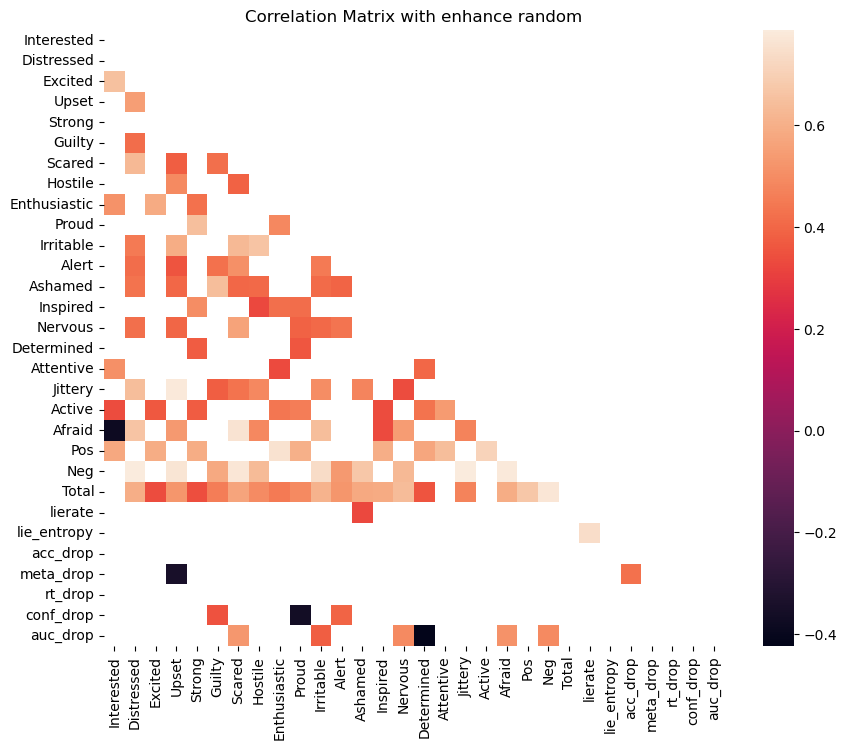

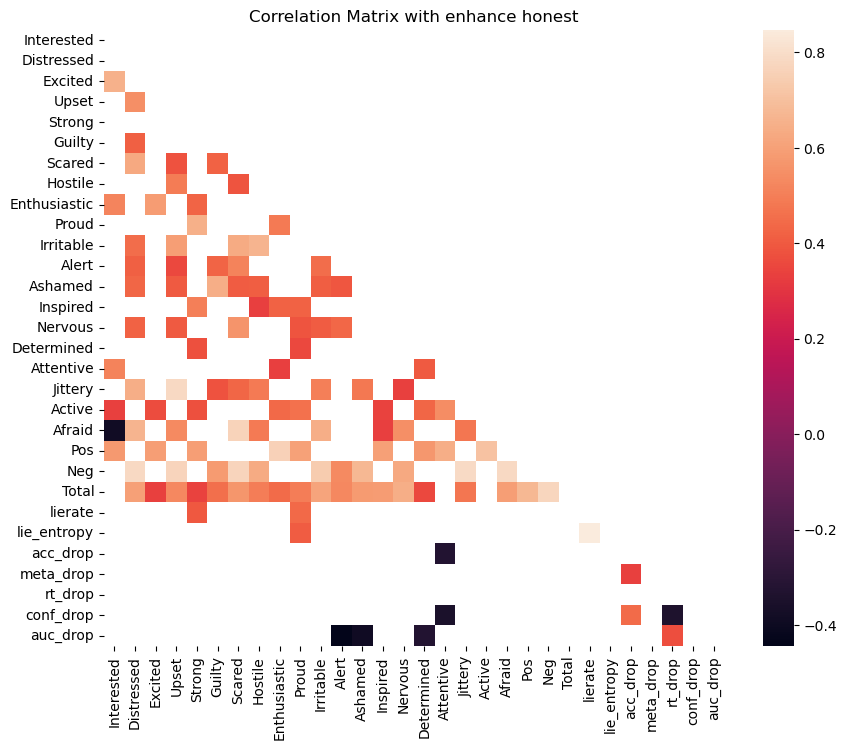

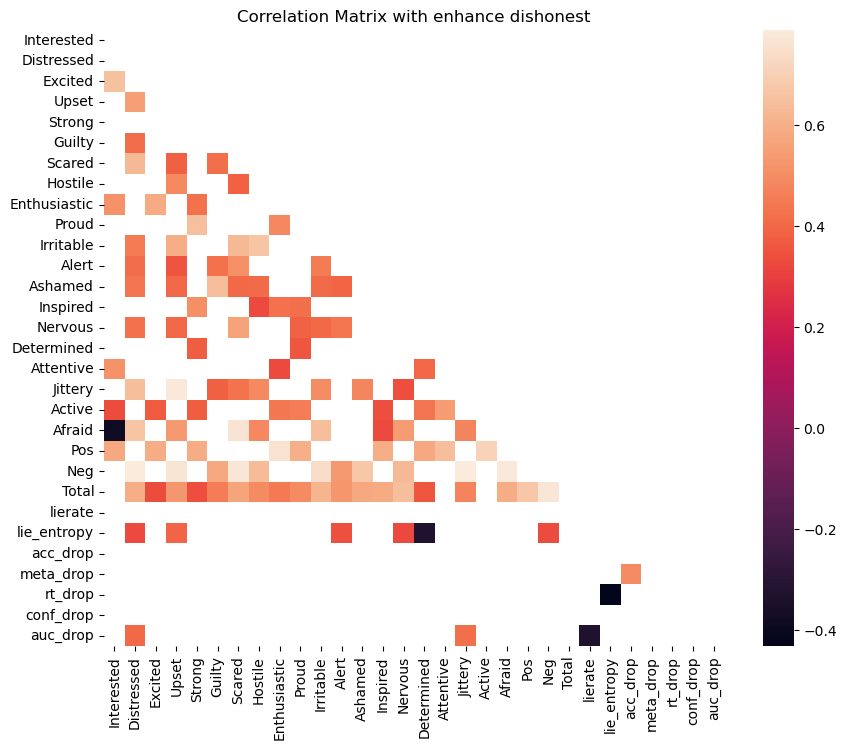

In [39]:
plot_correlation_map(df_random,'enhance random')
plot_correlation_map(df_honesty,'enhance honest')
plot_correlation_map(df_dishonesty,'enhance dishonest')

In [40]:
results = mediation_analysis(df_dishonesty, 'lierate', 'Guilty', 'acc_drop')
print_mediation_results(results)


Total effect c (X→Y):
  Coefficient: 0.1845
  p-value: 0.1281 (not significant)

Path a (X→M):
  Coefficient: 1.8807
  p-value: 0.0574 (not significant)

Path b (M→Y controlling for X):
  Coefficient: 0.0182
  p-value: 0.3908 (not significant)

Direct effect c' (X→Y controlling for M):
  Coefficient: 0.1502
  p-value: 0.2385 (not significant)

Indirect effect a*b (X→M→Y):
  Coefficient: 0.0343
  95.0% CI: [-0.0163, 0.1026]
  (not significant)


Mixed

In [41]:
data_mixed = np.zeros([len(sub_list_mixed), len(emotion_list)])

for i in range(len(sub_list_mixed)):
    for j in range(len(emotion_list)):
        col_nn = col_name_list_p[punish_emotion_list[j]]
        data_mixed[i,j] = df_mixed[col_nn][df_mixed.iloc[:, 6] == sub_list_mixed[i]].to_numpy()[0]

In [42]:
beh_list = ['lierate','lie_entropy','acc_drop','meta_drop','rt_drop','conf_drop','auc_drop']
data_beh = np.zeros([len(sub_list_mixed), len(beh_list)])
cond_index = 0 #change the condition index for the ['enhance_honesty', 'enhance_lie', 'enhance_random']
cond_list = ['enhance_honesty', 'enhance_lie', 'enhance_random']
for i in range(len(sub_list_mixed)):
    agg_sub = agg_m_lie_entro[agg_m_lie_entro['subj'] == sub_list_mixed[i]]
    data_beh[i,0] = agg_sub[agg_sub['condition'] == cond_list[cond_index]]['lierate'].to_numpy()[0]
    data_beh[i,1] = agg_sub[agg_sub['condition'] == cond_list[cond_index]]['entropy'].to_numpy()[0]


data_beh[:,3] = meta_mixed[:,cond_index,0] - meta_mixed[:,cond_index,1]
data_beh[:,2] = accuracy_mixed[:,cond_index,0] - accuracy_mixed[:,cond_index,1]
data_beh[:,4] = np.abs(rt_mixed[:,cond_index,0] - rt_mixed[:,cond_index,1])
data_beh[:,5] = confidence_mixed[:,cond_index,0] - confidence_mixed[:,cond_index,1]
data_beh[:,6] = auc_mixed[:,cond_index,0] - auc_mixed[:,cond_index,1]

data_total = np.concatenate((data_mixed, data_beh), axis=1)
column_list = ['Interested','Distressed','Excited','Upset','Strong','Guilty','Scared','Hostile','Enthusiastic','Proud','Irritable','Alert','Ashamed','Inspired','Nervous','Determined','Attentive','Jittery','Active','Afraid','Pos','Neg','Total','lierate','lie_entropy','acc_drop','meta_drop','rt_drop','conf_drop','auc_drop']
df_honesty = pd.DataFrame(data_total, columns=column_list)

corr = df_honesty.corr()
p_matrix = np.zeros_like(corr)
p_value_matrix = pd.DataFrame(p_matrix, index=corr.index, columns=corr.columns)
df_mixed_honest = p_value_matrix.applymap(lambda x: round(x, 4))
corr_mixed_honest = df_honesty.corr()

###########################################################################################################################
#honesty up
#dishonest down
###########################################################################################################################

beh_list = ['lierate','lie_entropy','acc_drop','meta_drop','rt_drop','conf_drop','auc_drop']
data_beh = np.zeros([len(sub_list_mixed), len(beh_list)])
cond_index = 1 #change the condition index for the ['enhance_honesty', 'enhance_lie', 'enhance_random']
cond_list = ['enhance_honesty', 'enhance_lie', 'enhance_random']
for i in range(len(sub_list_mixed)):
    agg_sub = agg_m_lie_entro[agg_m_lie_entro['subj'] == sub_list_mixed[i]]
    data_beh[i,0] = agg_sub[agg_sub['condition'] == cond_list[cond_index]]['lierate'].to_numpy()[0]
    data_beh[i,1] = agg_sub[agg_sub['condition'] == cond_list[cond_index]]['entropy'].to_numpy()[0]


data_beh[:,3] = meta_mixed[:,cond_index,0] - meta_mixed[:,cond_index,1]
data_beh[:,2] = accuracy_mixed[:,cond_index,0] - accuracy_mixed[:,cond_index,1]
data_beh[:,4] = np.abs(rt_mixed[:,cond_index,0] - rt_mixed[:,cond_index,1])
data_beh[:,5] = confidence_mixed[:,cond_index,0] - confidence_mixed[:,cond_index,1]
data_beh[:,6] = auc_mixed[:,cond_index,0] - auc_mixed[:,cond_index,1]

data_total = np.concatenate((data_mixed, data_beh), axis=1)
column_list = ['Interested','Distressed','Excited','Upset','Strong','Guilty','Scared','Hostile','Enthusiastic','Proud','Irritable','Alert','Ashamed','Inspired','Nervous','Determined','Attentive','Jittery','Active','Afraid','Pos','Neg','Total','lierate','lie_entropy','acc_drop','meta_drop','rt_drop','conf_drop','auc_drop']
df_dishonest = pd.DataFrame(data_total, columns=column_list)

corr = df_dishonest.corr()
p_matrix = np.zeros_like(corr)
p_value_matrix = pd.DataFrame(p_matrix, index=corr.index, columns=corr.columns)
df_mixed_dishonest = p_value_matrix.applymap(lambda x: round(x, 4))
corr_mixed_dishonest = df_dishonest.corr()

###########################################################################################################################
#dishonesty up
#random down
###########################################################################################################################

beh_list = ['lierate','lie_entropy','acc_drop','meta_drop','rt_drop','conf_drop','auc_drop']
data_beh = np.zeros([len(sub_list_mixed), len(beh_list)])
cond_index = 2 #change the condition index for the ['enhance_honesty', 'enhance_lie', 'enhance_random']
cond_list = ['enhance_honesty', 'enhance_lie', 'enhance_random']
for i in range(len(sub_list_mixed)):
    agg_sub = agg_m_lie_entro[agg_m_lie_entro['subj'] == sub_list_mixed[i]]
    data_beh[i,0] = agg_sub[agg_sub['condition'] == cond_list[cond_index]]['lierate'].to_numpy()[0]
    data_beh[i,1] = agg_sub[agg_sub['condition'] == cond_list[cond_index]]['entropy'].to_numpy()[0]


data_beh[:,3] = meta_mixed[:,cond_index,0] - meta_mixed[:,cond_index,1]
data_beh[:,2] = accuracy_mixed[:,cond_index,0] - accuracy_mixed[:,cond_index,1]
data_beh[:,4] = np.abs(rt_mixed[:,cond_index,0] - rt_mixed[:,cond_index,1])
data_beh[:,5] = confidence_mixed[:,cond_index,0] - confidence_mixed[:,cond_index,1]
data_beh[:,6] = auc_mixed[:,cond_index,0] - auc_mixed[:,cond_index,1]

data_total = np.concatenate((data_mixed, data_beh), axis=1)
column_list = ['Interested','Distressed','Excited','Upset','Strong','Guilty','Scared','Hostile','Enthusiastic','Proud','Irritable','Alert','Ashamed','Inspired','Nervous','Determined','Attentive','Jittery','Active','Afraid','Pos','Neg','Total','lierate','lie_entropy','acc_drop','meta_drop','rt_drop','conf_drop','auc_drop']
df_random = pd.DataFrame(data_total, columns=column_list)

corr = df_random.corr()
p_matrix = np.zeros_like(corr)
p_value_matrix = pd.DataFrame(p_matrix, index=corr.index, columns=corr.columns)
df_mixed_random = p_value_matrix.applymap(lambda x: round(x, 4))
corr_mixed_random = df_random.corr()

C:\Users\18611\AppData\Local\Temp\ipykernel_17816\3379618288.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_mixed_honest = p_value_matrix.applymap(lambda x: round(x, 4))
C:\Users\18611\AppData\Local\Temp\ipykernel_17816\3379618288.py:55: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_mixed_dishonest = p_value_matrix.applymap(lambda x: round(x, 4))
C:\Users\18611\AppData\Local\Temp\ipykernel_17816\3379618288.py:86: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_mixed_random = p_value_matrix.applymap(lambda x: round(x, 4))


In [43]:
file_path = "mixed_pvalue.xlsx"

# Save DataFrames to different sheets
with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
    df_mixed_dishonest.to_excel(writer, sheet_name='dishonest', index=False)
    df_mixed_honest.to_excel(writer, sheet_name='honest', index=False)
    df_mixed_random.to_excel(writer, sheet_name='random', index=False)
    
file_path = "mixed_corr.xlsx"

# Save DataFrames to different sheets
with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
    corr_mixed_dishonest.to_excel(writer, sheet_name='dishonest', index=False)
    corr_mixed_honest.to_excel(writer, sheet_name='honest', index=False)
    corr_mixed_random.to_excel(writer, sheet_name='random', index=False)

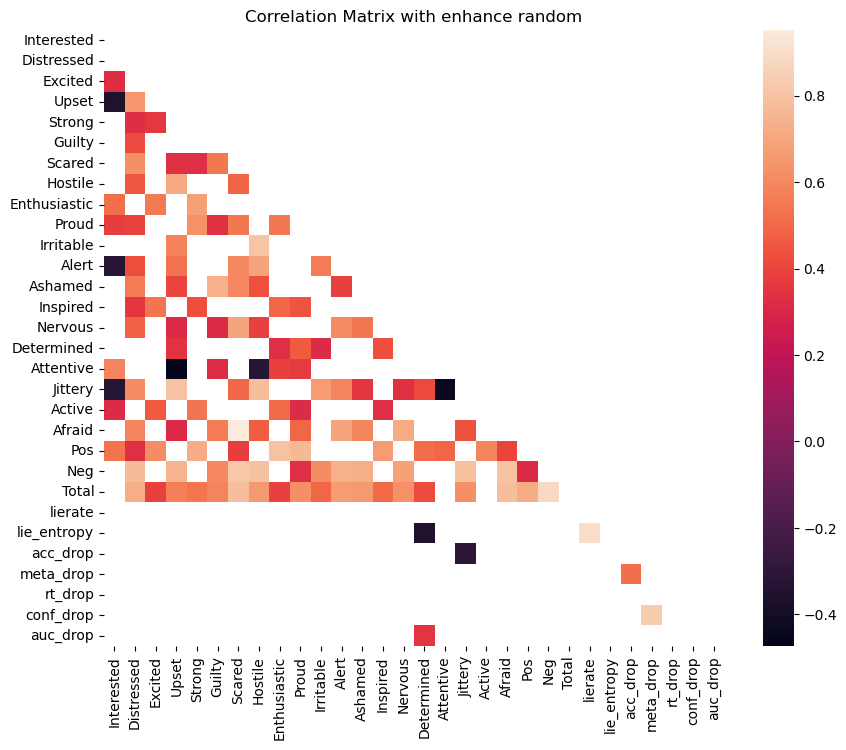

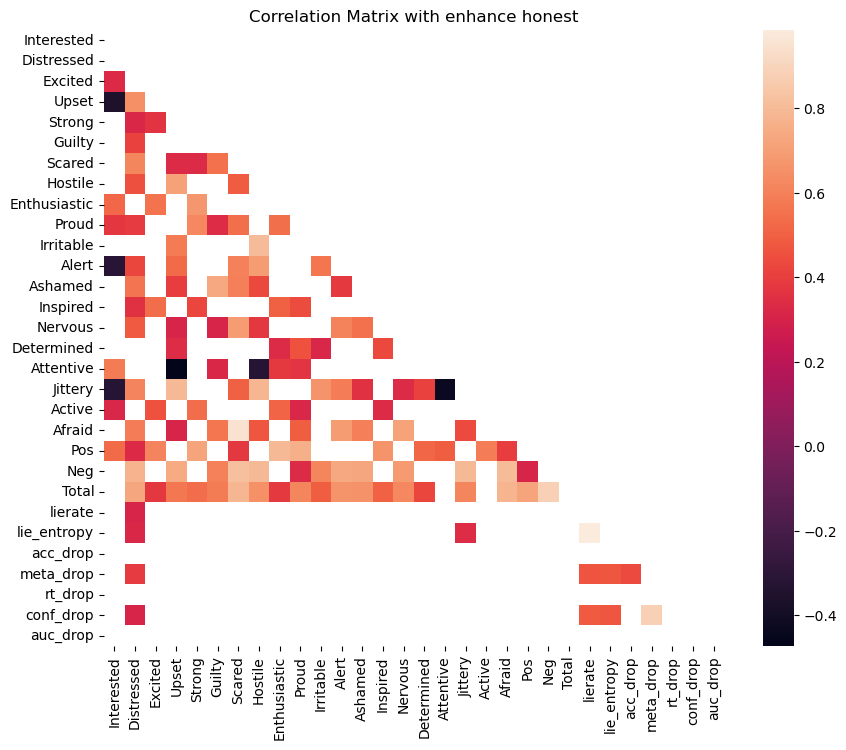

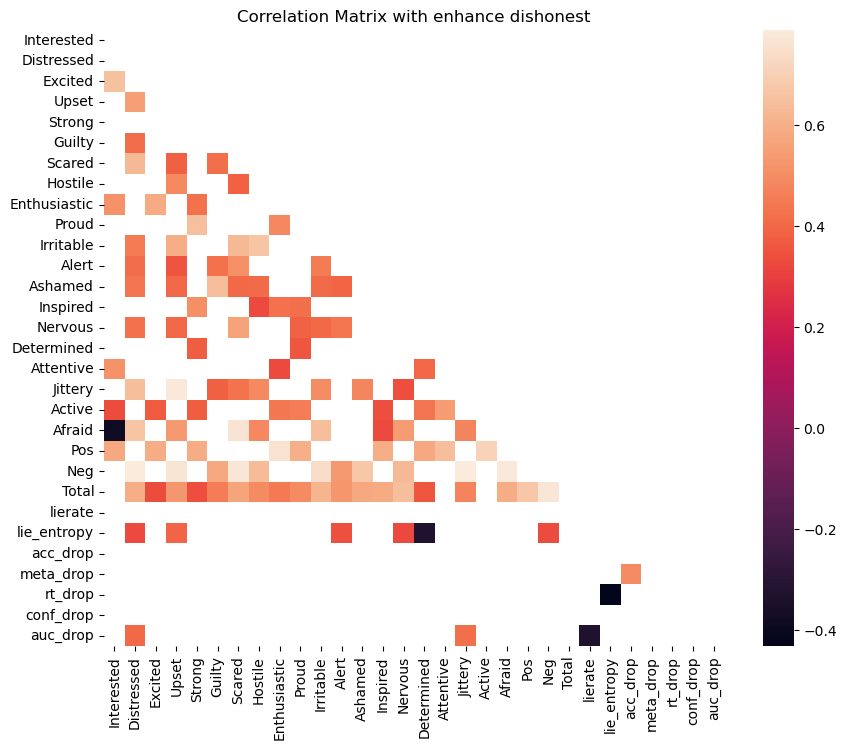

In [44]:
plot_correlation_map(df_random,'enhance random')
plot_correlation_map(df_honesty,'enhance honest')
plot_correlation_map(df_dishonesty,'enhance dishonest')

In [45]:
results = mediation_analysis(df_dishonesty, 'lierate', 'Guilty', 'acc_drop')
print_mediation_results(results)


Total effect c (X→Y):
  Coefficient: 0.1845
  p-value: 0.1281 (not significant)

Path a (X→M):
  Coefficient: 1.8807
  p-value: 0.0574 (not significant)

Path b (M→Y controlling for X):
  Coefficient: 0.0182
  p-value: 0.3908 (not significant)

Direct effect c' (X→Y controlling for M):
  Coefficient: 0.1502
  p-value: 0.2385 (not significant)

Indirect effect a*b (X→M→Y):
  Coefficient: 0.0343
  95.0% CI: [-0.0181, 0.1007]
  (not significant)


Compare the behavior performance among the three conditions


In [46]:
def analyze_stages(data_matrix, metric_name, condition_name):


    stages = ['pre', 'post', 'post2']
    stage_data = []
    

    for stage in range(data_matrix.shape[2]):  # Loop through stages
        stage_values = data_matrix[:, :, stage].mean(axis=1)  # Average across conditions
        stage_data.append(stage_values)
    

    f_stat, p_value = f_oneway(*stage_data)
    

    all_values = np.concatenate(stage_data)
    stage_labels = np.repeat(stages, len(stage_data[0]))
    
 
    tukey = pairwise_tukeyhsd(all_values, stage_labels, alpha=0.05)
    means = [np.mean(stage) for stage in stage_data]
    sems = [np.std(stage) / np.sqrt(len(stage)) for stage in stage_data]
    
    return {
        'f_statistic': f_stat,
        'p_value': p_value,
        'tukey_results': tukey,
        'means': means,
        'sems': sems
    }

def plot_stage_comparison(results, metric_name, condition_name, save_path=None):

    plt.figure(figsize=(10, 6))
    
    # Bar plot
    stages = ['pre', 'post', 'post2']
    x = np.arange(len(stages))
    plt.bar(x, results['means'], yerr=results['sems'], capsize=5, 
            alpha=0.7, color='skyblue', width=0.6)
    
    plt.xlabel('Stage', fontsize=12, fontweight='bold')
    plt.ylabel(f'{metric_name}', fontsize=12, fontweight='bold')
    plt.title(f'{metric_name} Across Stages - {condition_name}', 
              fontsize=14, fontweight='bold', pad=20)
    
    
    plt.xticks(x, stages)
    plt.tight_layout()
    plt.show()

def analyze_and_plot_all_metrics(rt_data, acc_data, conf_data, mad_data, auc_data, meta_data, condition_name):

    metrics = {
        'Response Time': rt_data,
        'Accuracy': acc_data,
        'Confidence': conf_data,
        'MAD': mad_data,
        'AUC': auc_data,
        'Meta-d\'': meta_data
    }
    
    results = {}
    for metric_name, data in metrics.items():

        result = analyze_stages(data, metric_name, condition_name)
        results[metric_name] = result
        
        # below is plot the figure
        #plot_stage_comparison(result, metric_name, condition_name)
        
    return results

In [47]:
'''
results = analyze_stages(rt_reward, "Response Time", "Reward")
plot_stage_comparison(results, "Response Time", "Reward")
'''

results_reward = analyze_and_plot_all_metrics(
    rt_reward, accuracy_reward, confidence_reward, 
    mad_reward, auc_reward, meta_reward, 
    "Reward"
)

results_punish = analyze_and_plot_all_metrics(
    rt_punish, accuracy_punish, confidence_punish, 
    mad_punish, auc_punish, meta_punish, 
    "Punish"
)

results_mixed = analyze_and_plot_all_metrics(
    rt_mixed, accuracy_mixed, confidence_mixed, 
    mad_mixed, auc_mixed, meta_mixed, 
    "Mixed"
)
#extract value use code like below:
#results_reward['Accuracy']['p_value']

In [48]:
results_mixed

{'Response Time': {'f_statistic': 12.64196444488517,
  'p_value': 1.0418860168070371e-05,
  'tukey_results': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x29508264e90>,
  'means': [1234.3133468834687, 1162.9004065040651, 1334.304539295393],
  'sems': [20.087601694961233, 21.508415798680446, 29.156291525306564]},
 'Accuracy': {'f_statistic': 13.18105947465519,
  'p_value': 6.6858012611336565e-06,
  'tukey_results': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x2950822d910>,
  'means': [0.9786585365853661, 0.9712059620596207, 0.9339430894308942],
  'sems': [0.003894855606472131, 0.005716612592702492, 0.00892125537176429]},
 'Confidence': {'f_statistic': 5.341765305145408,
  'p_value': 0.005992709401458553,
  'tukey_results': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x2950822ffd0>,
  'means': [96.85481029810299, 95.9841463414634, 91.99065040650407],
  'sems': [0.7493822047026619, 1.1927314113902334, 1.3046122524621364]},
 'MAD': {'f_statistic': 1.639